# Notes, Work, and Code

## Preparation

In [309]:
### IMPORTED PACKAGES ###

library(ggplot2) # data visualization
library(tidyverse) # dataset manipulation (includes dplyr)

# PCA calculation and visualization
library(factoextra)
library(FactoMineR)

In [310]:
### MAIN DATAFRAMES ###

# load dataset
sharks = read.table("datasets/shark_immunity.txt", header = TRUE, sep = "\t")

# change the order the physiological conditions are displayed 
sharks$physiological_condition <- factor(
  sharks$physiological_condition,
  levels = c("Healthy", "Stressed", "Injured", "Infected", "Recovering")
)
# reduces name to just the gene
names(sharks) <- sub("_expression", "", names(sharks))
# add identification based on immune cell type and physiological condition
sharks$group = paste(sharks$physiological_condition, sharks$immune_cell_type, sep="_")

# dataframe with gene expression split into 2 variables
shark_genes = sharks %>% 
    pivot_longer(
        cols = starts_with("Gene_"),
        names_to = "gene",
        values_to = "expression"
    )
    
# dataframe where all numerical variables are split into 2 variables
sharks_super_long = sharks %>%
    select(physiological_condition, immune_cell_type, Gene_A, Gene_B, Gene_C, Gene_D, Gene_E, Gene_F, regeneration_capacity, age_years, immune_receptor_diversity, response_to_infection, inflammation_level, weight_kg, habitat_location,resilience_score, reproduction_rate) %>% 
  
    pivot_longer(
        cols = -c("physiological_condition","immune_cell_type","Gene_A","Gene_B","Gene_C","Gene_D","Gene_E","Gene_F","habitat_location"), 
        names_to = "variable", 
        values_to = "value") %>%
    
        select(physiological_condition, immune_cell_type, Gene_A, Gene_B, Gene_C, Gene_D, Gene_E, Gene_F,habitat_location,variable,value) %>% 
    
        pivot_longer(
            cols = -c("physiological_condition","immune_cell_type","habitat_location","variable","value"),
            names_to = "gene",
            values_to = "expression")

In [311]:
### DATA SELECTION FUNCTIONS ###
condition_data = function(data, condition) { data[data$physiological_condition==condition, ] }

cell_data = function(data, cell_type) { data[data$immune_cell_type==cell_type, ] }

## 1. Immune Response Profiles of Different Immune Cell Types in the Infected Condition

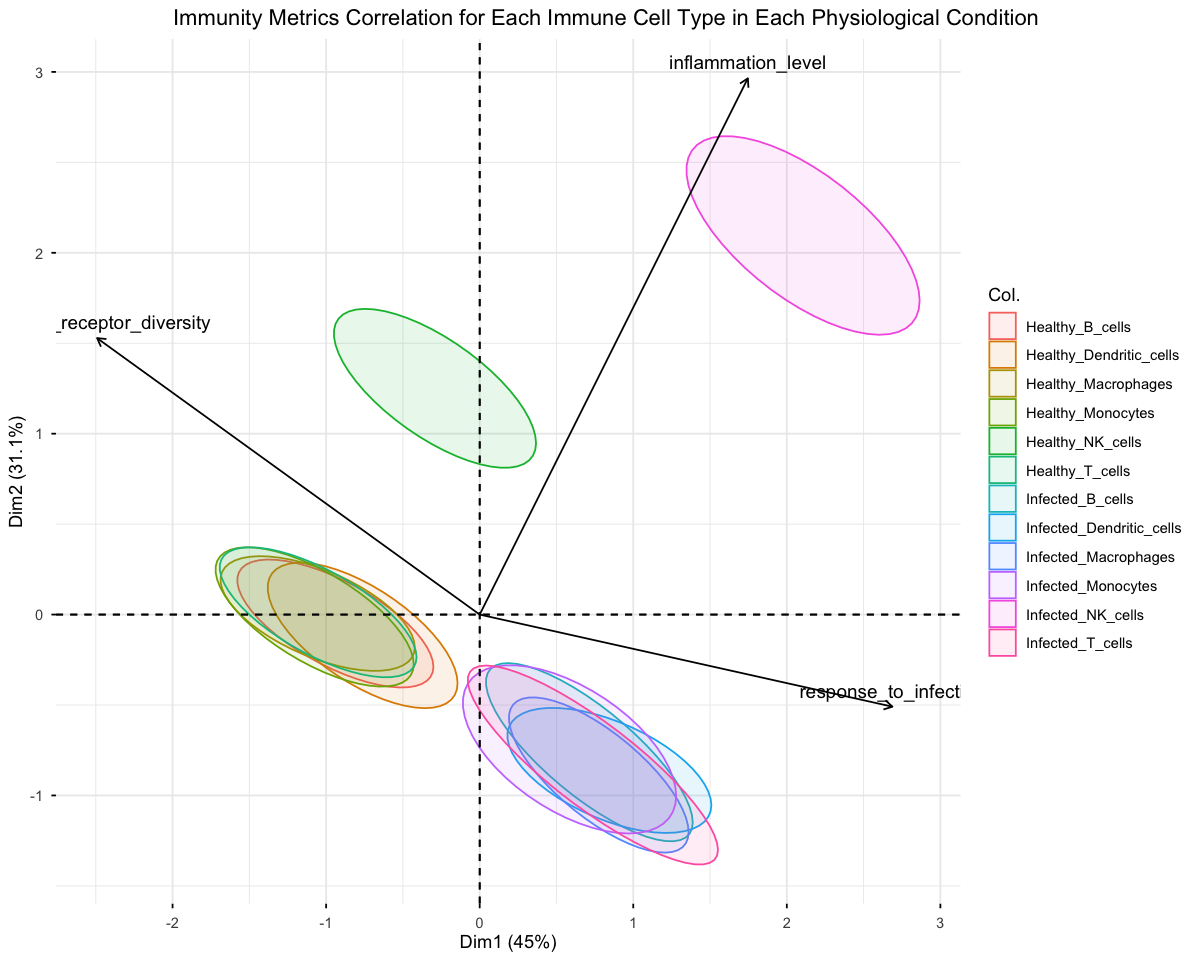

In [312]:
# healthy and infected population
healthy_infected = sharks %>% filter(physiological_condition %in% c("Healthy", "Infected"))

# PCA on response to infection, inflammation level, and immune receptor diversity metrics
h_inf_pca <- PCA(healthy_infected[c("response_to_infection","inflammation_level","immune_receptor_diversity")], scale.unit = TRUE, graph = FALSE)

# customize graph size
options(repr.plot.width=10, repr.plot.height=8)

# MDS cloud plot with correlation circle
fviz_pca_biplot(h_inf_pca, geom.ind="None", col.ind=healthy_infected$group, col.var="black", addEllipses=TRUE, ellipse.level=0.5, title="Immunity Metrics Correlation for Each Immune Cell Type in Each Physiological Condition") +
    theme(plot.title=element_text(hjust=3))


To properly determine the immune response profile of different immune cells types in the infectd condition, I need to compare it to that of the healthy condition.

It seems that the NK cells are distiguished from other immune cell types by their inflammation level. 

It also seems that the difference between the healthy and infected conditions is that the healthy cells are more correlated with immune receptor diversity while the infected cells are more correlated with response to infection, which is also true for NK cells.

### Inflammation Level Profile

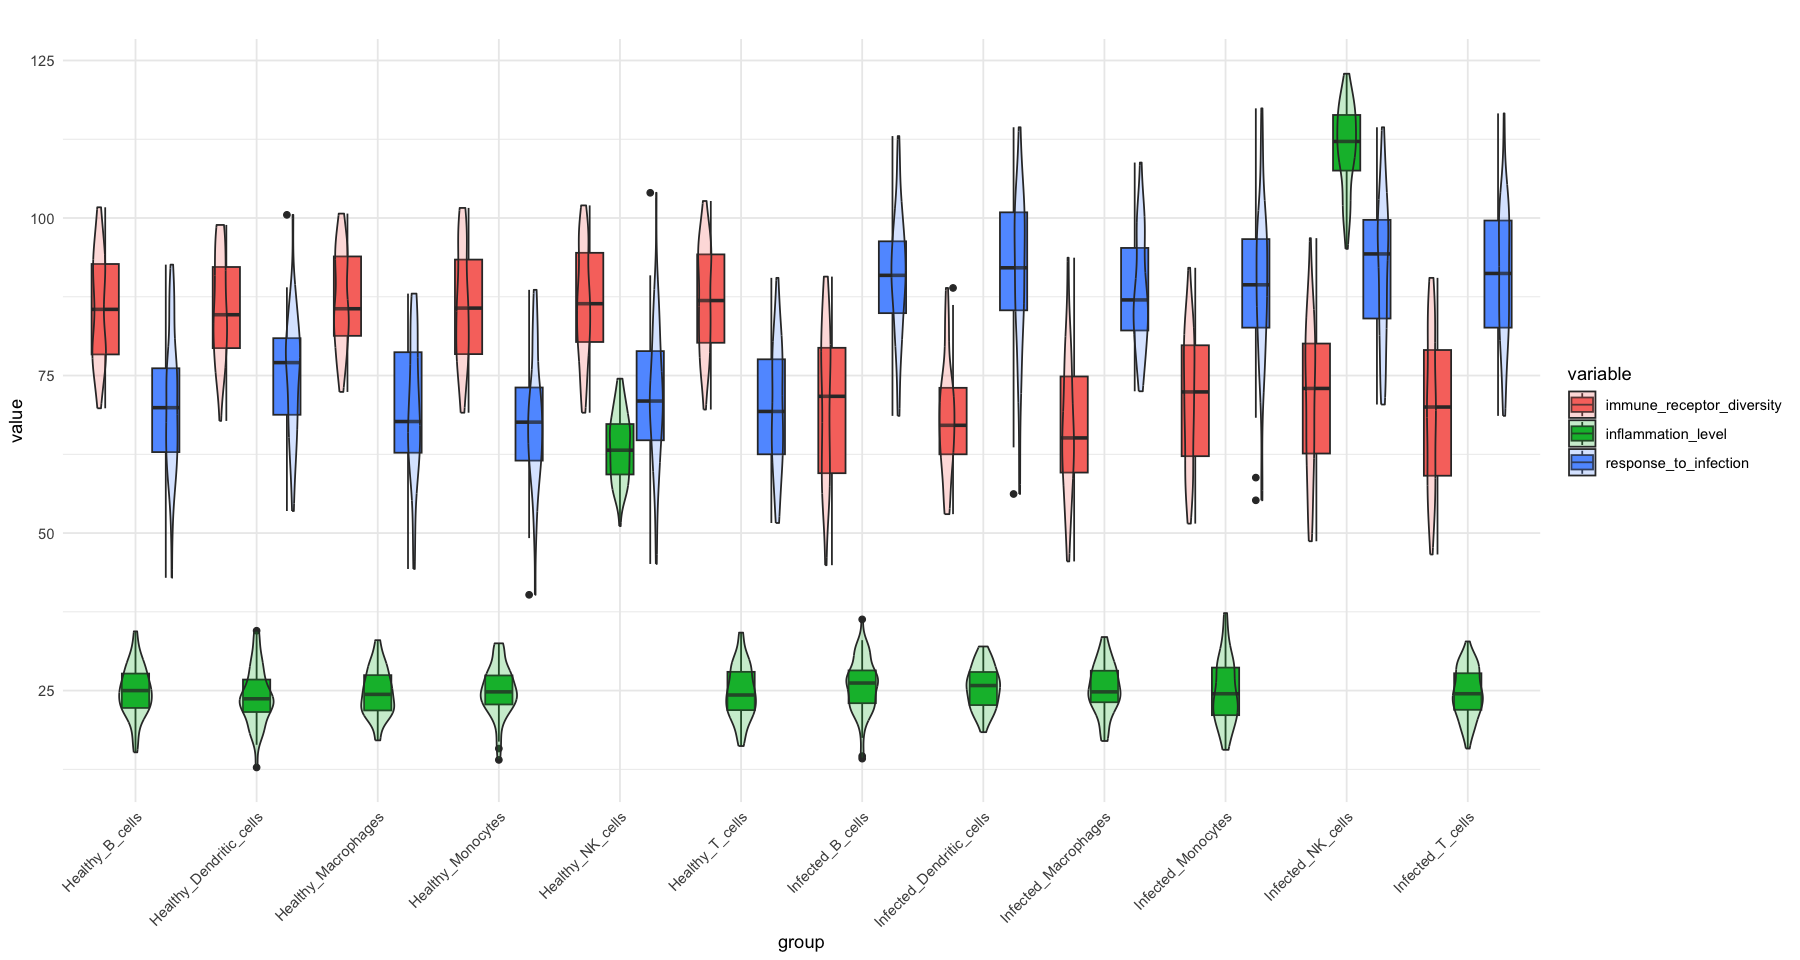

In [313]:
# long dataframe for healthy and infected populations on immune response metrics
h_inf_immune = healthy_infected[c("physiological_condition","immune_cell_type","immune_receptor_diversity","response_to_infection","inflammation_level","group")] %>%
    pivot_longer(
        cols = -c("physiological_condition","immune_cell_type","group"),
        names_to = "variable",
        values_to = "value"
    )

# customize graph size
options(repr.plot.width=15, repr.plot.height=8)

ggplot(h_inf_immune, aes(x=group, y=value, fill=variable)) +
    geom_boxplot() +
    geom_violin(alpha=0.25) +
    theme_minimal() +
    theme(
        axis.text.x=element_text(angle=45, hjust=1),
        plot.title=element_text(hjust=8)
    ) +
    ggtitle("Immune Response Levels Across Immune Cell Types in Healthy and Infected Conditions")

It seems that all immune cell types except NK cells had very similar inflammation levels, regardless of whether they were in healthy or infected conditions.

It also seems as though the infection response and immune receptor diversity profiles reverse between the healthy and infected conditions.

In [314]:
h_inf_inflam = h_inf_immune[h_inf_immune$variable=="inflammation_level", ]

# test the normality of the inflammation level data for healthy and infected populations
h_inf_inflam %>%
    group_by(group) %>%
    summarise(p_value = shapiro.test(value)$p.value)

group,p_value
<chr>,<dbl>
Healthy_B_cells,0.90525866
Healthy_Dendritic_cells,0.53154464
Healthy_Macrophages,0.65941410
Healthy_Monocytes,0.41745223
Healthy_NK_cells,0.38072358
Healthy_T_cells,0.46554625
Infected_B_cells,0.52597683
Infected_Dendritic_cells,0.86273029
Infected_Macrophages,0.97692907


The Shapiro-Wilks test confirms that the inflammation levels are normally distributed for each immune cell type in either healthy or infected conditions.

In [315]:
h_inf_inflam_anova = aov(data=healthy_infected, inflammation_level ~ group)
summary(h_inf_inflam_anova)

             Df Sum Sq Mean Sq F value Pr(>F)    
group        11 492138   44740    2142 <2e-16 ***
Residuals   708  14789      21                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

ANOVA confirms that a statistical difference exists between the groups (physiological conditio-immune cell type).

In [316]:
head((TukeyHSD(h_inf_inflam_anova)$group))

,diff,lwr,upr,p adj
Healthy_Dendritic_cells-Healthy_B_cells,-0.79869478,-3.516269,1.918880,0.9983427
Healthy_Macrophages-Healthy_B_cells,-0.21343837,-3.122910,2.696033,1.0000000
Healthy_Monocytes-Healthy_B_cells,0.04472627,-2.533334,2.622786,1.0000000
Healthy_NK_cells-Healthy_B_cells,38.84477369,36.448699,41.240849,0.0000000
Healthy_T_cells-Healthy_B_cells,-0.15664052,-2.462647,2.149366,1.0000000
Infected_B_cells-Healthy_B_cells,0.83271548,-1.649507,3.314938,0.9946525


In [347]:
h_inf_inflam_tukey = (TukeyHSD(h_inf_inflam_anova)$group)

diff_res = h_inf_inflam_tukey[h_inf_inflam_tukey[,"p adj"] < 0.05, "p adj"]

pair_lst = as.list(names(diff_res))

In [345]:
not_NK = logical()
has_NK = logical()
for (p in pair_lst) {
    ps = str_split_fixed(p, "-", 2)
    a = str_split_fixed(ps[1], "_", 2)
    b = str_split_fixed(ps[2], "_", 2)
    if (a[2] != "NK_cells" && b[2] != "NK_cells") { not_NK = c(not_NK, TRUE) }
    if (a[2] == "NK_cells" || b[2] == "NK_cells") { has_NK = c(has_NK, TRUE) }
}
length(pair_lst)
length(chk_NK)
length(has_NK)

[1] 21

[1] 0

[1] 21

In [318]:
healthy_NK = list(); infected_NK = list()
h = 1; i = 1

for (p in pair_lst) {
    ps = str_split_fixed(paste(p),"-",2)
    if (ps[1] == "Healthy_NK_cells") { 
        healthy_NK[[h]] = ps[2]
        h = h + 1
    }
    if (ps[2] == "Healthy_NK_cells") { 
        healthy_NK[[h]] = ps[1]
        h = h + 1
    }
    if (ps[1] == "Infected_NK_cells") { 
        infected_NK[[i]] = ps[2]
        i = i + 1
    }
    if (ps[2] == "Infected_NK_cells") { 
        infected_NK[[i]] = ps[1]
        i = i + 1
    }
}

In [319]:
healthy_NK_h = list(); healthy_NK_i = list()
h = 1; i = 1

for (x in healthy_NK) {
    aux = str_split_fixed(x,"_",2)
    if (aux[1] == "Healthy") { 
        healthy_NK_h[h] = aux[2]
        h = h + 1
    }
    if (aux[2] == "Healthy") { 
        healthy_NK_h[h] = aux[1]
        h = h + 1
    }
    if (aux[1] == "Infected") { 
        healthy_NK_i[i] = aux[2]
        i = i + 1
    }
    if (aux[2] == "Infected") { 
        healthy_NK_i[i] = aux[1]
        i = i + 1
    }
}

infected_NK_h = list(); infected_NK_i = list()
h = 1; i = 1
for (x in infected_NK) {
    aux = str_split_fixed(x,"_",2)
    if (aux[1] == "Healthy") { 
        infected_NK_h[h] = aux[2]
        h = h + 1
    }
    if (aux[2] == "Healthy") { 
        infected_NK_h[h] = aux[1]
        h = h + 1
    }
    if (aux[1] == "Infected") { 
        infected_NK_i[i] = aux[2]
        i = i + 1
    }
    if (aux[2] == "Infected") { 
        infected_NK_i[i] = aux[1]
        i = i + 1
    }
}

In [326]:
partner_groups = list(healthy_NK_h, healthy_NK_i, infected_NK_h, infected_NK_i)

cell_types = as.list(unique(sharks$immune_cell_type))

res = logical()
for (g in partner_groups) {
    for (t in cell_types) {
        res = c(res, t %in% g)
    }
}

partner_matrix = matrix(
    res,
    nrow = 4,
    ncol = 6,
    byrow = TRUE
)
rownames(partner_matrix) = c("H - H", "H - I", "I - H", "I - I")
colnames(partner_matrix) = cell_types

partner_matrix

,Monocytes,Dendritic_cells,T_cells,NK_cells,B_cells,Macrophages
H - H,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE
H - I,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
I - H,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
I - I,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE


### Immune Response and Immune Receptor Diversity Profiles

# Analysis of Dataset 3 | The Fangs of Immunity : Resilience of the Shark Immune System

## Presentation of the Dataset

1345 observations accounting for 17 variables (not counting the observation ID)

Qualitative Variables 
| variable | values |
| :-: | :-: |
| physiological condition | Healthy, Stressed, Injured, Infected, Recovering |
| immune cell type | Monocytes, Dendritic Cells, T Cells, NK Cells, B Cells, Macrophages |
| habitat location | Indian, Southern, Artic, Pacific, Atlantic |

Quantitative Variables
| variable | min | max | average | standard deviation | variance |
| :-: | :-: | :-: | :-: | :-: | :-: |
| gene expression (6x : A, B, C, D, E, F) | 32.75 | 218.8 | 117.32 | 37.47 | 1402.98 |
| regeneration capacity | 83.2 | 151.9 | 119.0 | 12.55 | 157.48 |
| age (years) | 5.00 | 60.00 | 32.91 | 16.15 | 260.96 |
| immune receptor diversity | 44.9 | 102.7 | 73.4 | 12.79 | 163.60 |
| response to infection | 40.20 | 118.30 | 77.85 | 13.09 | 171.29 |
| inflammation level | 12.80 | 122.90 | 35.97 | 24.35 | 592.81 |
| weight (kg) | 276.2 | 679.7 | 498.1 | 62.05 | 3850.53 |
| resilience score | 98.9 | 174.1 | 128.6 | 13.45 | 180.97 |
| reproduction rate | 6.90 | 25.00 | 14.86 | 5.04 | 25.42 |

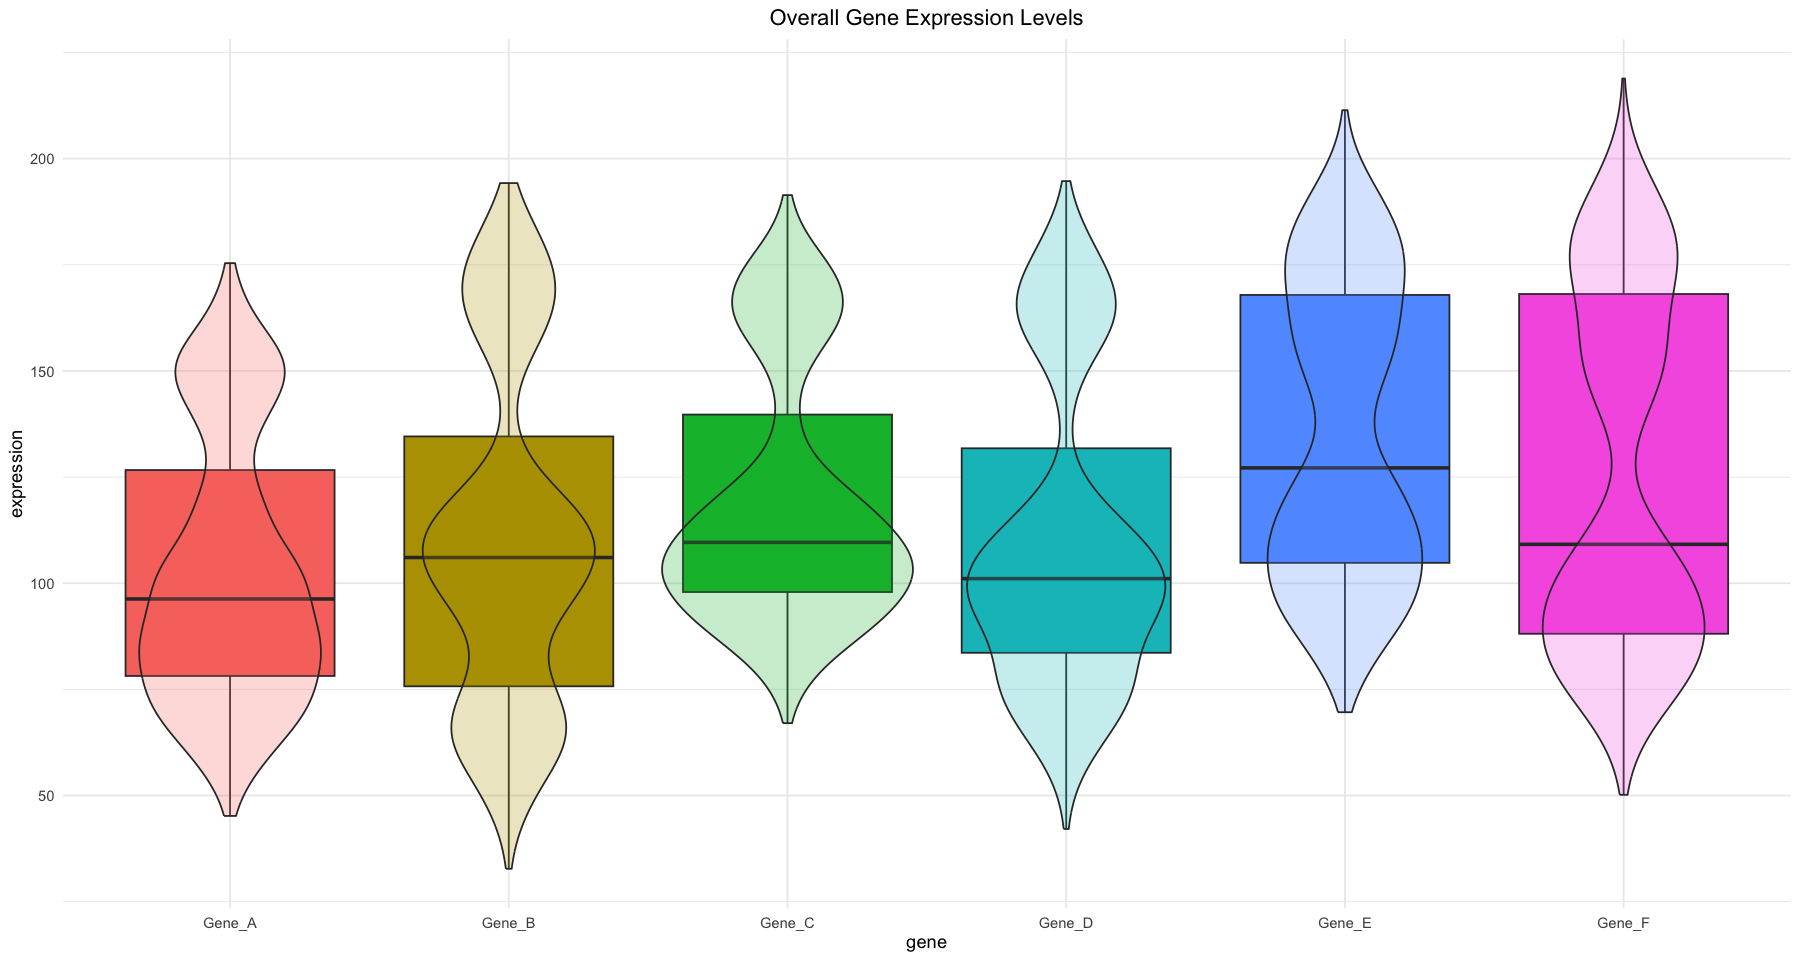

In [321]:
# visualizing expression levels for each gene
ggplot(shark_genes, aes(x=gene,y=expression,fill=gene)) +
    geom_boxplot() +
    geom_violin(alpha=0.25) +
    theme_minimal() +
    theme(
        plot.title=element_text(hjust=0.5),
        legend.position="None"
    ) +
    ggtitle("Overall Gene Expression Levels")

In [322]:
# code obtain information on the dataset
sprintf("%d entries, %d categories (not including )", nrow(sharks), ncol(sharks)-1)
names(sharks)
unique(sharks$physiological_condition)
unique(sharks$immune_cell_type)
unique(sharks$habitat_location)
summary(sharks)

[1] "1345 entries, 18 categories (not including )"

[1] "ID"                        "physiological_condition"  
 [3] "immune_cell_type"          "Gene_A"                   
 [5] "Gene_B"                    "Gene_C"                   
 [7] "Gene_D"                    "Gene_E"                   
 [9] "Gene_F"                    "regeneration_capacity"    
[11] "age_years"                 "immune_receptor_diversity"
[13] "response_to_infection"     "inflammation_level"       
[15] "weight_kg"                 "habitat_location"         
[17] "resilience_score"          "reproduction_rate"        
[19] "group"

[1] Infected   Injured    Healthy    Stressed   Recovering
Levels: Healthy Stressed Injured Infected Recovering

[1] "Monocytes"       "Dendritic_cells" "T_cells"         "NK_cells"       
[5] "B_cells"         "Macrophages"

[1] "Indian"   "Southern" "Arctic"   "Pacific"  "Atlantic"

       ID       physiological_condition immune_cell_type       Gene_A      
 Min.   :   1   Healthy   :387          Length:1345        Min.   : 45.20  
 1st Qu.: 337   Stressed  :201          Class :character   1st Qu.: 78.16  
 Median : 673   Injured   :271          Mode  :character   Median : 96.29  
 Mean   : 673   Infected  :333                             Mean   :102.87  
 3rd Qu.:1009   Recovering:153                             3rd Qu.:126.66  
 Max.   :1345                                              Max.   :175.39  
     Gene_B           Gene_C           Gene_D           Gene_E      
 Min.   : 32.75   Min.   : 67.05   Min.   : 42.13   Min.   : 69.62  
 1st Qu.: 75.73   1st Qu.: 97.93   1st Qu.: 83.62   1st Qu.:104.80  
 Median :106.06   Median :109.63   Median :101.09   Median :127.16  
 Mean   :110.53   Mean   :119.42   Mean   :110.17   Mean   :135.18  
 3rd Qu.:134.58   3rd Qu.:139.72   3rd Qu.:131.79   3rd Qu.:167.90  
 Max.   :194.24   Max.   :191.41   Max.   :194.71   Ma

## Scientific Questions

1. Do the immune reponse profiles differ from one immune cell type to another in the infected condition? If so, how so?

## Analytical Approaches and Methods Used

### Immune Response Profiles of Different Immune Cell Types in the Infected Condition

## Results Obtained

## Conclusions